# Coursera Week 3 Part 1

In [6]:
import pandas as pd
import numpy as np
print("Importing complete")

Importing complete


Reading table

In [7]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [8]:
df['Borough'].value_counts()

Not assigned        77
Etobicoke           44
North York          38
Scarborough         37
Downtown Toronto    37
Central Toronto     17
West Toronto        13
York                 9
East Toronto         7
East York            6
Mississauga          1
Queen's Park         1
Name: Borough, dtype: int64

In [9]:
df['Neighbourhood'].value_counts()

Not assigned                                         78
Runnymede                                             2
St. James Town                                        2
South Niagara                                         1
York Mills                                            1
Glencairn                                             1
Richview Gardens                                      1
Tam O'Shanter                                         1
Dorset Park                                           1
Cliffside                                             1
High Park                                             1
Cliffside West                                        1
St. Phillips                                          1
The Danforth West                                     1
Old Mill South                                        1
Wexford                                               1
King's Mill Park                                      1
Newtonbrook                                     

## Clean 'Borough' column

In [10]:
df['Borough'].replace('Not assigned',np.nan,inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df['Borough'].value_counts()

Etobicoke           44
North York          38
Scarborough         37
Downtown Toronto    37
Central Toronto     17
West Toronto        13
York                 9
East Toronto         7
East York            6
Mississauga          1
Queen's Park         1
Name: Borough, dtype: int64

## Clean 'Neighbourhood' column

In [11]:
#this finds nameless neighbourhoods
df['Neighbourhood'].replace('Not assigned',np.nan,inplace=True)
df[df.Neighbourhood.isna()]

,Postcode,Borough,Neighbourhood
5,M7A,Queen's Park,NaN


In [12]:
#this renames the nameless neighbourhoods with their borough names
df.at[5,'Neighbourhood']=df.at[5,'Borough']
df.loc[5]

Postcode                  M7A
Borough          Queen's Park
Neighbourhood    Queen's Park
Name: 5, dtype: object

## Collapse neighbourhoods into zipcodes

In [13]:
#this code groups the neighborhoods by postcode, then concatenates the neighborhoods
df1=df
df2 = pd.DataFrame(columns = df1.columns)
ix = 0
for key,value in df1.groupby(['Postcode']).groups.items():
    ns=''
    b = df1.loc[value[0]][1]
    for indexdf in value:
        n = df1.loc[indexdf][2]
        ns+= n + ", "
    ns=ns.rstrip(", ")
    df2.loc[ix] = [key,b,ns]
    ix+=1
    

df2.head()         

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [14]:
df2.shape

(103, 3)

# Coursera Week 3 Part 2

Geocoder was too unreliable, below is my code for my initial try, followed by reading in the CSV

In [15]:
#Geocoder too unreliable
#!conda install -c conda-forge geocoder --yes
#import geocoder 

In [16]:
#This is how I'd try if geocoder worked
#new dataframe to merge later
'''df3 = pd.DataFrame(columns = ["Latitude","Longitude"])
df3.head()
for i in range(df2.shape[0]):
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    count = 0
    while(lat_lng_coords is None):
        count+=1
        g = geocoder.google('{}, Toronto, Ontario'.format(df2.iloc[i][0]))
        lat_lng_coords = g.latlng
    print("Row " + str(i) + " took " + str(count) + " tries.")
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    #update dataframe
    df3.loc[i]=[latitude,longitude]
df3.head() '''  

'df3 = pd.DataFrame(columns = ["Latitude","Longitude"])\ndf3.head()\nfor i in range(df2.shape[0]):\n    # initialize your variable to None\n    lat_lng_coords = None\n\n    # loop until you get the coordinates\n    count = 0\n    while(lat_lng_coords is None):\n        count+=1\n        g = geocoder.google(\'{}, Toronto, Ontario\'.format(df2.iloc[i][0]))\n        lat_lng_coords = g.latlng\n    print("Row " + str(i) + " took " + str(count) + " tries.")\n    latitude = lat_lng_coords[0]\n    longitude = lat_lng_coords[1]\n    #update dataframe\n    df3.loc[i]=[latitude,longitude]\ndf3.head() '

In [17]:
#Reading in provided csv worked flawlessly
df3 = pd.read_csv("Geospatial_Coordinates.csv")
df3.columns = ["Postcode","Latitude","Longitude"]
df3.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## Part 2 final dataframe

In [18]:
df3=df3.merge(df2,on="Postcode")
df3.head()

,Postcode,Latitude,Longitude,Borough,Neighbourhood
0,M1B,43.806686,-79.194353,Scarborough,"Rouge, Malvern"
1,M1C,43.784535,-79.160497,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,43.770992,-79.216917,Scarborough,Woburn
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae


# Coursera Week 3 Part 3

Explore and cluster neighborhoods in Toronto.  Maps included.

In [19]:
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium
import requests
import json
df4=df3
CLIENT_ID = '3B3T4ZAT2ADVQ15YL0QJ3H2DUFNYLBQ3W4J4KJWI5WDVG0PE' # your Foursquare ID
CLIENT_SECRET = 'YGXJYCHEJ410LTZKYP5FGQF4C1GQTOBTGMP0EJC1YTINVTSF' # your Foursquare Secret
VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

torll = [43.6487,-79.38544]

Your credentails:
CLIENT_ID: 3B3T4ZAT2ADVQ15YL0QJ3H2DUFNYLBQ3W4J4KJWI5WDVG0PE
CLIENT_SECRET:YGXJYCHEJ410LTZKYP5FGQF4C1GQTOBTGMP0EJC1YTINVTSF


## Create map of neighborhoods for visualization


In [20]:
# create map of Manhattan using latitude and longitude values
map_tor = folium.Map(location=torll, zoom_start=10)

# add markers to map
for lat, lng, label in zip(df3['Latitude'], df3['Longitude'], df3['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
    
map_tor

## Foursquare exploration

In [21]:
#taking a look at how data is extracted for some item in our dataset
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, df3["Latitude"][11], df3["Longitude"][11], VERSION, 500, 50)
results = requests.get(url).json()
results=results['response']['groups'][0]['items']
results[0]['venue']['location']

{'lat': 43.746098,
 'lng': -79.293142,
 'labeledLatLngs': [{'label': 'display', 'lat': 43.746098, 'lng': -79.293142}],
 'distance': 492,
 'cc': 'CA',
 'country': 'Canada',
 'formattedAddress': ['Canada']}

 This loop calls foursquare for each post code and then lists the top 20 (if possible) venues within 1 km.

In [22]:
venuesdf = pd.DataFrame(columns = ["Postcode","Neighbourhood","Name","Category","vlat",'vlong'])
radius = 1000
lim=50
count=0
for ix in range(df4.shape[0]):
    
    [post,nlat,nlong,b,n] = df4.loc[ix]
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, nlat, nlong, VERSION, radius, lim)
    results = requests.get(url).json()['response']['groups'][0]['items']
    for venue in results:
        temp = venue['venue']
        venuesdf.loc[count]=[post,n,temp['name'],temp['categories'][0]['name'],temp['location']['lat'],temp['location']['lng']]
        count+=1
venuesdf.head()

,Postcode,Neighbourhood,Name,Category,vlat,vlong
0,M1B,"Rouge, Malvern",Images Salon & Spa,Spa,43.802283,-79.198565
1,M1B,"Rouge, Malvern",Caribbean Wave,Caribbean Restaurant,43.798558,-79.195777
2,M1B,"Rouge, Malvern",Wendy's,Fast Food Restaurant,43.802008,-79.198080
3,M1B,"Rouge, Malvern",Wendy's,Fast Food Restaurant,43.807448,-79.199056
4,M1B,"Rouge, Malvern",Staples Morningside,Paper / Office Supplies Store,43.800285,-79.196607


## Compiling and summarizing venue data for each neighbourhood

In [23]:
#looking at trends in summary data
venuesdf.shape
venuesdf.groupby('Postcode').count()
#venuesdf.groupby('Category').count()

,Neighbourhood,Name,Category,vlat,vlong
Postcode,,,,,
M1B,17,17,17,17,17
M1C,5,5,5,5,5
M1E,25,25,25,25,25
M1G,9,9,9,9,9
M1H,28,28,28,28,28
M1J,12,12,12,12,12
M1K,29,29,29,29,29
M1L,31,31,31,31,31
M1M,12,12,12,12,12


In [24]:
venuesdf2 = pd.get_dummies(venuesdf['Category'], prefix="", prefix_sep="")
venuesdf2['Neighbourhood'] = venuesdf.Neighbourhood

In [25]:

cols = venuesdf2.columns.tolist()
cols.reverse()
venuesdf3 = venuesdf2[cols]
venuesdf3.head()

,Neighbourhood,Zoo,Yoga Studio,Women's Store,Wings Joint,Wine Shop,Wine Bar,Warehouse Store,Vietnamese Restaurant,Video Store,...,Argentinian Restaurant,Aquarium,Antique Shop,Animal Shelter,Amphitheater,American Restaurant,Airport Lounge,Airport,Afghan Restaurant,Accessories Store
0,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Rouge, Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
andf = venuesdf3.groupby('Neighbourhood').mean().reset_index()
andf.head()

,Neighbourhood,Zoo,Yoga Studio,Women's Store,Wings Joint,Wine Shop,Wine Bar,Warehouse Store,Vietnamese Restaurant,Video Store,...,Argentinian Restaurant,Aquarium,Antique Shop,Animal Shelter,Amphitheater,American Restaurant,Airport Lounge,Airport,Afghan Restaurant,Accessories Store
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.040000,0.0,0.0,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.020408,0.0,0.0,0.0,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.071429,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## Finding top 5 for each neighbourhood

In [27]:
rankedf = pd.DataFrame(columns = ['Neighbourhood','First','Second','Third','Fourth','Fifth'])
for ix in range(andf.shape[0]):
    a=andf.loc[ix][1:].astype('float').nlargest()
    a=[x if y!=0 else "None" for x,y in a.items()]
    rankedf.loc[ix] = [andf['Neighbourhood'][ix],a[0],a[1],a[2],a[3],a[4]]
rankedf.head()
    

,Neighbourhood,First,Second,Third,Fourth,Fifth
0,"Adelaide, King, Richmond",Café,Coffee Shop,Steakhouse,Hotel,Concert Hall
1,Agincourt,Chinese Restaurant,Shopping Mall,Supermarket,Coffee Shop,Caribbean Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,Pizza Place,Park,Noodle House,Vegetarian / Vegan Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza Place,Grocery Store,Video Store,Sandwich Place,Pharmacy
4,"Alderwood, Long Branch",Pharmacy,Discount Store,Pizza Place,Park,Convenience Store


In [28]:
rankedf.groupby('First').count()

,Neighbourhood,Second,Third,Fourth,Fifth
First,,,,,
Bakery,1,1,1,1,1
Bar,2,2,2,2,2
Café,12,12,12,12,12
Chinese Restaurant,3,3,3,3,3
Coffee Shop,20,20,20,20,20
Discount Store,1,1,1,1,1
Electronics Store,1,1,1,1,1
Fast Food Restaurant,3,3,3,3,3
Furniture / Home Store,4,4,4,4,4


## KMeans clustering based on dataframe grouped with averages

In [29]:
from sklearn.cluster import KMeans
andf2 = andf.drop('Neighbourhood',1)
andf2.head()

,Zoo,Yoga Studio,Women's Store,Wings Joint,Wine Shop,Wine Bar,Warehouse Store,Vietnamese Restaurant,Video Store,Video Game Store,...,Argentinian Restaurant,Aquarium,Antique Shop,Animal Shelter,Amphitheater,American Restaurant,Airport Lounge,Airport,Afghan Restaurant,Accessories Store
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.040000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020408,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.020408,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.071429,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [31]:
import matplotlib.pyplot as mpl

[4.715879975619555, 4.340532550231059, 4.059104774532336, 3.9418325064543627, 3.7995167570392034, 3.6813445589383313, 3.541153787386251]


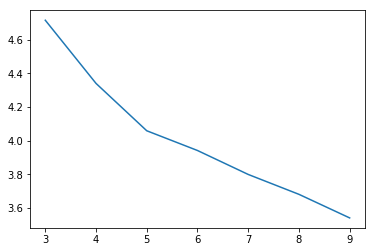

In [33]:
err = []
for k in range(3,10):
    kmmodel = KMeans(n_clusters = k, random_state = 0 ).fit(andf2)
    err.append(kmmodel.inertia_)
print(err)
mpl.plot(range(3,10),err) 

k = 5
kmmodel = KMeans(n_clusters = k, random_state = 0 ).fit(andf2)
labels = kmmodel.labels_

## Compiling all data (especially clusters) into 1 dataframe

In [246]:
finaldf=rankedf
finaldf.insert(0,'Cluster',labels)
finaldf.head()
finaldf = finaldf.join(df3.set_index('Neighbourhood'),on='Neighbourhood')
finaldf.head()

,Cluster,Neighbourhood,First,Second,Third,Fourth,Fifth,Postcode,Latitude,Longitude,Borough
0,3,"Adelaide, King, Richmond",Café,Coffee Shop,Steakhouse,Hotel,Concert Hall,M5H,43.650571,-79.384568,Downtown Toronto
1,0,Agincourt,Chinese Restaurant,Shopping Mall,Supermarket,Restaurant,Caribbean Restaurant,M1S,43.794200,-79.262029,Scarborough
2,0,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,Pizza Place,Park,Bakery,Vegetarian / Vegan Restaurant,M1V,43.815252,-79.284577,Scarborough
3,0,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza Place,Grocery Store,Sandwich Place,Pharmacy,Park,M9V,43.739416,-79.588437,Etobicoke
4,0,"Alderwood, Long Branch",Pharmacy,Discount Store,Pizza Place,Park,Convenience Store,M8W,43.602414,-79.543484,Etobicoke


## Visualization of K Means Clustering

In [248]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [250]:
# create map
map_clusters = folium.Map(location=torll, zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(finaldf['Latitude'], finaldf['Longitude'], finaldf['Neighbourhood'], finaldf['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 1

In [253]:
finaldf[finaldf['Cluster']==0].head()

,Cluster,Neighbourhood,First,Second,Third,Fourth,Fifth,Postcode,Latitude,Longitude,Borough
1,0,Agincourt,Chinese Restaurant,Shopping Mall,Supermarket,Restaurant,Caribbean Restaurant,M1S,43.794200,-79.262029,Scarborough
2,0,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,Pizza Place,Park,Bakery,Vegetarian / Vegan Restaurant,M1V,43.815252,-79.284577,Scarborough
3,0,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza Place,Grocery Store,Sandwich Place,Pharmacy,Park,M9V,43.739416,-79.588437,Etobicoke
4,0,"Alderwood, Long Branch",Pharmacy,Discount Store,Pizza Place,Park,Convenience Store,M8W,43.602414,-79.543484,Etobicoke
5,0,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Trail,Sushi Restaurant,Supermarket,Ski Chalet,M3H,43.754328,-79.442259,North York


Cluster 2

In [254]:
finaldf[finaldf['Cluster']==1].head()

,Cluster,Neighbourhood,First,Second,Third,Fourth,Fifth,Postcode,Latitude,Longitude,Borough
70,1,Northwest,Rental Car Location,Coffee Shop,None,None,None,M9W,43.706748,-79.594054,Etobicoke


Cluster 3

In [255]:
finaldf[finaldf['Cluster']==2].head()

,Cluster,Neighbourhood,First,Second,Third,Fourth,Fifth,Postcode,Latitude,Longitude,Borough
26,2,"Cloverdale, Islington, Martin Grove, Princess ...",Park,Pizza Place,Theater,Mexican Restaurant,Hotel,M9B,43.650943,-79.554724,Etobicoke
42,2,"Emery, Humberlea",Storage Facility,Park,Intersection,Golf Course,Gas Station,M9M,43.724766,-79.532242,North York
53,2,"Highland Creek, Rouge Hill, Port Union",Playground,Park,Italian Restaurant,Burger Joint,Breakfast Spot,M1C,43.784535,-79.160497,Scarborough
56,2,"Humber Bay, King's Mill Park, Kingsway Park So...",Park,Italian Restaurant,Shopping Mall,Ice Cream Shop,Gym / Fitness Center,M8Y,43.636258,-79.498509,Etobicoke
81,2,"Silver Hills, York Mills",Park,Pool,None,None,None,M2L,43.757490,-79.374714,North York


Cluster 4

In [256]:
finaldf[finaldf['Cluster']==3].head()

,Cluster,Neighbourhood,First,Second,Third,Fourth,Fifth,Postcode,Latitude,Longitude,Borough
0,3,"Adelaide, King, Richmond",Café,Coffee Shop,Steakhouse,Hotel,Concert Hall,M5H,43.650571,-79.384568,Downtown Toronto
7,3,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Fast Food Restaurant,Wings Joint,Video Store,M5M,43.733283,-79.419750,North York
8,3,Berczy Park,Coffee Shop,Café,Beer Bar,Seafood Restaurant,Park,M5E,43.644771,-79.373306,Downtown Toronto
9,3,"Birch Cliff, Cliffside West",Park,Thai Restaurant,Skating Rink,Restaurant,Gym Pool,M1N,43.692657,-79.264848,Scarborough
11,3,"Brockton, Exhibition Place, Parkdale Village",Café,Coffee Shop,Bakery,Restaurant,Hotel,M6K,43.636847,-79.428191,West Toronto


Cluster 5

In [257]:
finaldf[finaldf['Cluster']==4].head()

,Cluster,Neighbourhood,First,Second,Third,Fourth,Fifth,Postcode,Latitude,Longitude,Borough
36,4,Downsview Central,Vietnamese Restaurant,Restaurant,Baseball Field,None,None,M3M,43.728496,-79.495697,North York
